### Shapley Value

Machine Learning의 복잡한 기여도를 계산하기 위한 또 다른 방법은 바로 Shapley Value를 사용하는 것이다. Lloyd Shapleyrk가 1953년 제안한 개념으로, **협력 게임이론에서 전체 이익을 플레이어 각각의 기여도에 맞게 이익을 분배**하는 방법이다. 게임이론에서 차용된 개념이기 때문에, Machine Learning 모형에 맞춰 재정의할 필요가 있다.

- Game : 데이터셋에서 단일 instance에 대한 예측
- Gain : 해당 단일 instance에 대한 예측값에서 전체의 평균 예측값을 뺀 것
- Players : 해당 단일 instance의 feature

즉, Shapley Value는 모든 가능한 feature 부분 집합에 대한 평균적인 이익의 기여도로 해석할 수 있다. 여기서는 각 feature가 예측값에 기여한 정도를 계산한 것이라고 생각하면 된다

In [1]:
import pandas as pd
import numpy as np
from FinancialMachineLearning.generator.classification_data import get_test_data

In [2]:
trnsX, cont = get_test_data(
    n_features = 20, 
    n_informative = 5, 
    n_redundant = 5, 
    n_samples = 1000
)

In [3]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 1,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

선형 모형을 다음과 같이 가정해 보자. 여기서 $x$는 하나의 instance이다

$$\hat{f}(x) = \beta_0 + \beta_1 + \cdots + \beta_p x_p$$

예측값 $\hat{f}(x)$에 대한 $j$번째 feature의 기여도 $\phi_j$는 다음과 같다

$$\phi_j(\hat{f}) = \beta_j x_j - E(\beta_j X_j) = \beta_j x_j - \beta_j E(X_j)$$

하나의 instance에 대해 모든 feature의 기여도를 합치면 예측값에서 전체 데이터의 예측값 평균을 뺀 것과 같다

$$
\begin{matrix}
\sum_{j=1}^p \phi_j(\hat{f}) & = & \sum_{j=1}^p \left( \beta_j x_j - E(\beta_j X_j)\right) \\
       & = & \left( \beta_0 + \sum_{j=1}^p \beta_j x_j \right) - \left( \beta_0 + \sum_{j=1}^p E(\beta_j X_j)\right) \\
       & = & \hat{f}(x) - E(\hat{f}(X))
\end{matrix}
$$

Shapley value는 플레이어들의 가치 함수(value function)를 사용하여 정의한다. Shapley value를 머신러닝에 맞춰 설명한다면, 피처의 Shapley value는 가능한 모든 가능한 피처 조합들의 기여도들의 가중치 합이다

모델에 사용한 피처들의 부분 집합 $S$, 피처의 개수 $p$에 대해서 다음과 같이 정의한다

$$\phi_j(\mathrm{value}) = \sum_{S \subseteq \{1, \cdots, p\} \setminus \{j\}}
\frac{|S|!(p - |S| - 1)!}{p!}(\mathrm{value}(S \cup \{j\}) - \mathrm{value}(S)) $$

데이터 instance의 feature vector $x$에 대해서 가치 함수 $\mathrm{value}_x(S)$는 다음과 같이 정의한다

$$\mathrm{value}_x(S) = \int \hat{f}(x_1, \cdots, x_p) d\mathbb{P}_{x \notin S} - E_X(\hat{f}(X))$$

#### Shapley Value의 네 가지 특성

1. 모든 $j$에 대해서 $ϕ_j$의 합은 항상 예측값에서 전체 예측값의 평균을 뺀 것과 같아진다. 더 엄밀하게 말하자면 가치 함수와 같아진다

$$\sum_{j=1}^p \phi_j = \hat{f}(x) - E_X(\hat{f}(X))$$

2. 만약 두 feature $j$와 $k$가 모든 부분집합 $S$에 들어가지 않고 두 feature를 각각 포함한 가치 함수가 같다면 두 피처의 기여도는 반드시 같다
3. feature $j$가 예측값에 영향을 미치지 않는다면 feature $j$에 대한 Shapley value는 반드시 0이다
4. Shapley value는 다음의 성질을 만족한다

$$\phi_j(\mathrm{value} + \mathrm{value}^+) = \phi_j(\mathrm{value}) + \phi_j(\mathrm{value}^+)$$
$$\phi_j(a \times \mathrm{value}) = a \cdot \phi_j(\mathrm{value})$$

### SHAP Model

SHAP Model은 2017년 제안된 모형으로, Shapley Value를 기반으로 한 설명 기법이다. 모형은 다음과 같이 계산된다

$$g(z') = \phi_0 + \sum_{j=1}^{M} \phi_j$ z_j^'$$

여기서 $g$는 설명 모델, $z' \in 0, 1^M$은 coalition vector(연합 벡터), $M$은 최대 연합의 크기이고, $\phi_j \in \mathbb{R}$은 feature $j$에 대한 Shapley value이다

SHAP Model은 Shapley Value에 비해 다음과 같은 추가적인 특징을 가지고 있다

$$\mathrm{Local ~ Accuracy ~ : ~}\hat{f}(x) = g(x') = \phi_0 + \sum_{j=1}^M \phi_j x_j'$$
$$\mathrm{Missingness ~ : ~}x_j' = 0 \Rightarrow \phi_j = 0$$

$\hat{f}_x(z') = \hat{h_x(z')}$라 두고, $z_{\setminus j}'$가 $z_{j}' = 0$을 나타낼 때, 모든 입력값 $z' \in 0, 1^M$에 대해서 다음을 만족시키는 두 모델 $f$와 $f'$이 있다고 가정하자

$$\hat{f}_x'(z') - \hat{f}_x'(z_{\setminus j}') \geq \hat{f}_x(z') - \hat{f}_x(z_{\setminus j}')$$

그러면, $\phi_j$는 다음을 만족한다

$$\phi_j \left( {\hat{f}}^\prime, x \right) \geq \phi_j \left( \hat{f}, x \right)$$

이 특성은 모델이 피처 값의 marginal contribution이 증가하거나 같다면 Shapley value 역시 증가하거나 같음을 의미한다

SHAP Model은 python library `shap`를 불러와서 사용하면 쉽게 표현할 수 있다. 다음의 예제를 살펴보자

In [4]:
import shap

forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(trnsX)

각 feature의 SHAP Value는 다음과 같이 뽑아낼 수 있다

In [5]:
shap_values_train[:,:,1].values.mean(axis = 0)

array([ 9.67746641e-04,  6.33037719e-04, -1.22098578e-03, -7.80109432e-04,
        5.82746843e-04,  4.18276290e-04, -3.45521858e-03, -1.70390440e-03,
        3.53928398e-03, -6.12281681e-04,  3.06948004e-05,  1.25814391e-04,
        3.09520431e-05,  1.20543873e-04,  1.62758608e-04,  1.47395301e-04,
        1.96580401e-04,  1.84598996e-04, -2.42312507e-04,  2.40382496e-04])

shap의 plot.beeswarm을 통해 분포와 특성 중요도를 전부 출력할 수 있다

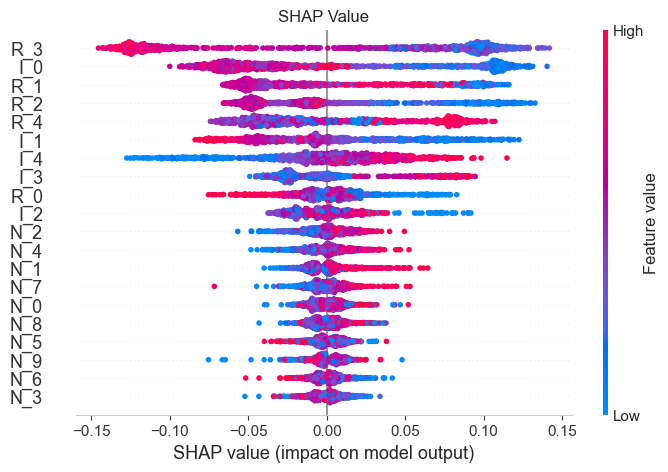

In [8]:
import matplotlib.pyplot as plt

plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (8, 5)
)
plt.show()

### Explainable Neural Network

Explainable Neural Networks (설명 가능한 신경망, ENN)은 신경망을 보다 해석 가능하고 이해할 수 있도록 하는 것을 목표로 한다. 기존의 신경망은 예측력에 있어서 강력한 성능을 제공하지만, 그 결정 과정이 Black Box 처럼 작용하여 결과를 설명하기 어렵다. Explainable Neural Network는 이러한 문제를 해결하기 위해 신경망의 출력을 설명할 수 있도록 한다.

**왜 설명 가능성이 중요한가?**

- 신뢰성:　포트폴리오 비중 결정은 특히 고도의 설명력을 요구하는 경우가 많다. 기존의 신경망 혹은 딥러닝 모형은 이러한 부분이 취약하며, 특히 senior manager들에게 공포 요소로 작용할 수 있다.
- 편향 탐지: 모델의 결정 과정을 투명하게 함으로써 편향을 식별하고 완화하기 쉽다. 모형 학습에 방해가 되는 변수를 미리 탐지함으로써 배제가 가능하다.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import statsmodels.api as sm
import sklearn

In [8]:
def generateProcess(
    number : int = 5000,
    random_sate : int = 42,
    number_of_X : int = 2,
) -> np.array :
    np.random.seed(random_sate) # Set NumPy's random seed for reproducibility
    X = np.zeros(shape = (number, number_of_X))
    for i in range(number_of_X) :
        X[:int(number/2), i] = np.random.randn(int(number/2))
        # Use antithetic sampling to reduce the bias in the mean
        X[int(number/2):, i] = -X[:int(number/2), i]
    
    eps = np.zeros(shape=(number,1))
    eps[:int(number/2)] = np.random.randn(int(number/2), 1)
    eps[int(number/2):] = -eps[:int(number/2)]
    
    Y = 0
    
    for i in range(number_of_X) : 
        Y += X[:, i]
        
    Y += eps.flatten()
    
    return Y, X

In [9]:
Y, X = generateProcess(number_of_X = 2)

#### Comparison to OLS

전통 통계학의 선형 모형인 OLS모형과 비교하기 위해, 우선 OLS의 적합화 결과부터 생성하기로 한다.

In [10]:
ols_result = sm.OLS(
    Y, 
    sm.add_constant(X)
).fit()

In [11]:
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     4479.
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        01:15:05   Log-Likelihood:                -7205.3
No. Observations:                5000   AIC:                         1.442e+04
Df Residuals:                    4997   BIC:                         1.444e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.435e-17      0.014  -9.92e-16      1.0

In [12]:
y_ols = ols_result.predict(sm.add_constant(X))

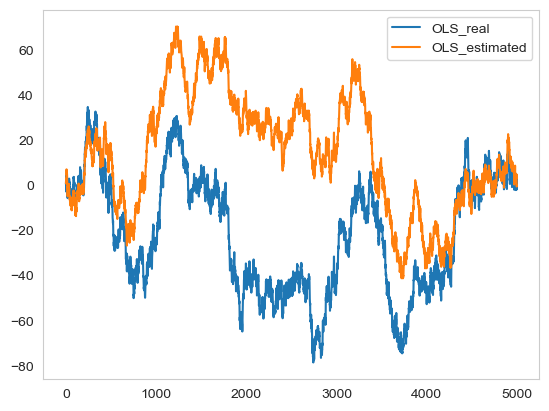

In [13]:
import matplotlib.pyplot as plt
plt.plot(Y.cumsum(), label = 'OLS_real')
plt.plot(y_ols.cumsum(), label = 'OLS_estimated')
plt.legend()
plt.grid(False)

#### Neural Network Interpretability

신경망 모형의 설명력을 설명하기에 앞서 데이터를 생성해 준다

In [14]:
def linear_NN0_model(l1_reg = .0, num_X_input : int = 2) :
    model = Sequential()
    model.add(
        Dense(1, input_dim = num_X_input, kernel_initializer = 'normal')
    )
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = ['mae','mse']
    )
    return model;

In [15]:
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 0, patience = 10)

In [16]:
linear_neural_network = KerasRegressor(
    build_fn = linear_NN0_model, 
    epochs = 40,
    batch_size = 10, 
    verbose = 0, 
    callbacks = [es]
)

linear_neural_network.fit(X, Y)

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
2024-05-26 01:15:05.720888: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
print("weights: " + str(linear_neural_network.model.layers[0].get_weights()[0]))
print("bias: " + str(linear_neural_network.model.layers[0].get_weights()[1]))

weights: [[0.99398005]
 [0.9581668 ]]
bias: [-0.00319311]


In [18]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])

paramter의 결과를 보면, OLS의 $\beta$ 추정치와 유사한 것을 알 수 있다.

#### Multi Layer Perceptron

모형의 설명력은 simple layer에만 국한되는 것이 아니다. 레이어가 2개 이상인 모형에서도 coefficient를 추정할 수 있다.

In [19]:
def linear_NN1_model(l1_reg = .0, num_X_input : int = 2) :
    model = Sequential()
    model.add(
        Dense(10, input_dim = num_X_input, kernel_initializer = 'normal')
    )
    model.add(
        Dense(1, kernel_initializer = 'normal', activation = 'linear')
    )
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = ['mae','mse']
    )
    return model

In [20]:
linear_neural_network = KerasRegressor(
    build_fn = linear_NN1_model, 
    epochs = 50,
    batch_size = 10, 
    verbose = 0, 
    callbacks = [es]
)
linear_neural_network.fit(X, Y)

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [21]:
W1 = linear_neural_network.model.get_weights()[0]
b1 = linear_neural_network.model.get_weights()[1]
W2 = linear_neural_network.model.get_weights()[2]
b2 = linear_neural_network.model.get_weights()[3]
print(W1, W2)

[[-0.3756998   0.32377648 -0.3518635   0.3059325   0.39519095 -0.11347371
   0.3062747   0.22624171  0.3128186   0.28849983]
 [-0.31073922  0.29474714 -0.35032842  0.3033891   0.2903557  -0.10054499
   0.29807281  0.32122815  0.35870042  0.3021996 ]] [[-0.34160906]
 [ 0.38017073]
 [-0.3308535 ]
 [ 0.38140056]
 [ 0.31228518]
 [-0.08013626]
 [ 0.37320554]
 [ 0.28235728]
 [ 0.36700752]
 [ 0.3075861 ]]


In [22]:
beta_0 = np.dot(np.transpose(W2), b1) + b2
beta_1 = np.dot(np.transpose(W2), W1[0])
beta_2 = np.dot(np.transpose(W2), W1[1])

In [23]:
print(beta_0, beta_1, beta_2)

[0.00702345] [0.9987663] [0.9750985]


In [24]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])

#### feedforward Neural Network

using $\tanh$ activation function

In [25]:
def linear_NN1_model_act(l1_reg = .0, num_X_input : int = 2) :
    model = Sequential()
    model.add(
        Dense(10, input_dim = num_X_input, kernel_initializer = 'normal', activation = 'tanh')
    )
    model.add(
        Dense(1, kernel_initializer = 'normal')
    )
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = ['mae','mse']
    )
    return model

In [26]:
linear_neural_network = KerasRegressor(
    build_fn = linear_NN1_model_act, 
    epochs = 50,
    batch_size = 10, 
    verbose = 0, 
    callbacks = [es]
)
linear_neural_network.fit(X, Y)

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [27]:
W1 = linear_neural_network.model.get_weights()[0]
b1 = linear_neural_network.model.get_weights()[1]
W2 = linear_neural_network.model.get_weights()[2]
b2 = linear_neural_network.model.get_weights()[3]
print(W1, W2)

[[-0.16833977 -0.15067574  0.15800086 -0.14997913  0.15425643  0.18227209
   0.20919755 -0.160483   -0.18096115  0.15484115]
 [-0.16520163 -0.19521296  0.18255422 -0.19660854  0.18854938  0.1434874
   0.10466807 -0.1785562  -0.14540637  0.1876151 ]] [[-0.6464192 ]
 [-0.5673758 ]
 [ 0.6550847 ]
 [-0.60763335]
 [ 0.56054676]
 [ 0.6412202 ]
 [ 0.69586694]
 [-0.67210495]
 [-0.6288843 ]
 [ 0.57190645]]


In [28]:
beta_0 = np.dot(np.transpose(W2), b1) + b2
beta_1 = np.dot(np.transpose(W2), W1[0])
beta_2 = np.dot(np.transpose(W2), W1[1])

In [29]:
print(beta_0, beta_1, beta_2)

[0.02823689] [1.0480819] [1.0458864]


In [30]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])

#### Sensitivity

민감도 분석은 입력의 작은 변화가 출력에 미치는 영향을 분석하여 신경망의 해석 가능성을 높이는 방법이다. 민감도 분석은 특정 입력 특징의 중요성을 이해하는 데 도움이 된다.

예를 들어, 신경망의 민감도 분석은 다음과 같이 수행될 수 있다:

입력 벡터 $X$와 출력 $y$가 있을 때, 각 입력 특징 $X_i$의 변화가 출력에 미치는 영향을 평가한다. 이때 민감도 $S_i$는 다음과 같이 계산될 수 있다

$$S_i = \left\vert \frac{\partial y}{\partial X_i} \right\vert$$

민감도 분석은 입력의 작은 변화를 출력에 반영함으로써 모델이 어떤 특징에 민감한지 추정할 수 있다.

In [31]:
def sensitivities(model, X) :
    W1 = model.model.get_weights()[0]
    b1 = model.model.get_weights()[1]
    W2 = model.model.get_weights()[2]
    b2 = model.model.get_weights()[3]
    
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    
    beta = np.array(
        [0] * M * (p+1),
        dtype = 'float64'
    ).reshape(M, p + 1)
    
    beta[:, 0] = (np.dot(np.transpose(W2), np.tanh(b1)) + b2)[0]
    for i in range(M) :
        Z1 = np.tanh(
            np.dot(
                np.transpose(W1), np.transpose(X[i,])
            ) + b1
        )
        D = np.diag(1 - Z1 ** 2);
        
        for j in range(p) :
            beta[i, j+1] = np.dot(np.transpose(W2), np.dot(D, W1[j]))
    
    return beta

In [32]:
beta = sensitivities(linear_neural_network, X)

Check that the intercept is close to one and the coefficients are close to one

In [33]:
print(np.mean(beta, axis = 0))

[0.02823664 0.99503983 0.99236385]


추정치의 분산을 확인할 수 있는데, 이는 t 분포의 신뢰구간과 유사한 기능을 한다.

In [34]:
print(np.std(beta, axis = 0))

[0.         0.06655508 0.06771299]


In [35]:
ols_result.params

array([-1.43529314e-17,  9.90927451e-01,  9.63554999e-01])